# LOAD & CLEAN

In [3]:
import numpy as np
import pandas as pd
import shap
import glob
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.metrics import root_mean_squared_error, recall_score, precision_score, precision_recall_curve, roc_auc_score, mean_absolute_error, r2_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 300)

In [4]:
SVRM3_ewon_df = pd.read_feather('SVRM3_ewon_complete.feather')
SVRM4_ewon_df = pd.read_feather('SVRM4_ewon_complete.feather')
temp_df = pd.read_feather('Temps_complete.feather')

In [5]:
def clean_data(df):
    df = df.drop_duplicates()
    
    df = df.copy()
    df['TimeStr'] = pd.to_datetime(df['TimeStr'], format="%d/%m/%Y %H:%M:%S")
    
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')
    
    df = df.replace(["Undef", "nan"], np.nan)
    
    mask = (df.iloc[:, 2:].isna()).all(axis=1)
    print(len(mask), "rows only have NaN entries (except Timestamps)")
    df_not_nan = df[~mask]
    
    df_not_nan = df_not_nan.dropna(axis=1, how='all')
    
    subset=["TimeStr"]
    
    print(len(df_not_nan[df_not_nan.duplicated(subset=subset)]), "rows are duplicated on TimeStr")
    df_cleaned = df_not_nan.loc[
    df_not_nan.assign(n_missing=df_not_nan.isna().sum(axis=1))
      .sort_values("n_missing")
      .drop_duplicates(subset=subset, keep="first")
      .index
]
    
    # temporary: remove wisselblok settings columns, none of them is relevant currently
    cols_to_drop = [col for col in df_cleaned.columns if "wisselblok_settings" in col.lower()]
    df_cleaned = df_cleaned.drop(columns=cols_to_drop)

    df_cleaned = df_cleaned.sort_values('TimeStr')
    
    print(len(df_cleaned), "rows retained. Data is cleaned")
    return df_cleaned

def combine_columns(df, col1, col2, new_col_name=None):
    """
    Combines two columns into one.
    Priority: col1 value first, otherwise col2 value.
    If both are NaN → result is NaN.

    Parameters:
        df (pd.DataFrame): the original dataframe
        col1 (str): first column name
        col2 (str): second column name
        new_col_name (str): name for the new column 
                            (default: col1)

    Returns:
        pd.DataFrame with the combined column
    """

    if new_col_name is None:
        new_col_name = col1

    df[new_col_name] = df[col1].combine_first(df[col2])
    df = df.drop([col2], axis=1)
    return df

# SVRM3 EWON TOTAAL AANTAL ONLY CONTAINS UNDEF AND 0

In [6]:
SVRM3_ewon_df_cleaned = clean_data(SVRM3_ewon_df)
SVRM4_ewon_df_cleaned = clean_data(SVRM4_ewon_df)

C:\Users\ravin\AppData\Local\Temp\ipykernel_7164\2941674888.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(["Undef", "nan"], np.nan)


821177 rows only have NaN entries (except Timestamps)
395 rows are duplicated on TimeStr
820690 rows retained. Data is cleaned


C:\Users\ravin\AppData\Local\Temp\ipykernel_7164\2941674888.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(["Undef", "nan"], np.nan)


746060 rows only have NaN entries (except Timestamps)
1204 rows are duplicated on TimeStr
744742 rows retained. Data is cleaned


In [7]:
column_pairs_SVRM3 = [
    ("BeginVerduningPosHor", "StangHistorie[1].BeginVerduningPosHor"),
    ("BeginVerdunningPos", "StangHistorie[1].BeginVerdunningPos"),
    ("EindVerduningPos", "StangHistorie[1].EindVerduningPos"),
    ("EindVerduningPosHor", "StangHistorie[1].EindVerduningPosHor"),
    ("Pos-UitloCor_2_trek24", "StangData.Pos-UitloCor_2_trek24"),
    ("Pos_inloCor_1_trek13", "StangData.Pos_inloCor_1_trek13"),
    ("Pos_inloCor_1_trek24", "StangData.Pos_inloCor_1_trek24"),
    ("Pos_inloCor_2_trek13", "StangData.Pos_inloCor_2_trek13"),
    ("Pos_uitloCor_1_trek13", "StangData.Pos_uitloCor_1_trek13"),
    ("Pos_uitloCor_1_trek24", "StangData.Pos_uitloCor_1_trek24"),
    ("Pos_uitloCor_2_trek13", "StangData.Pos_uitloCor_2_trek13"),
    ("Pos_inloCor_2_trek24", "StangData.Pos_inloCor_2_trek24"),
    ("bgem", "StangHistorie[1].bgem"),
    ("dgem", "StangHistorie[1].dgem"),
    ("Lengte_verduning", "StangHistorie[1].L_v")
]

column_pairs_SVRM4 = [
    ("BeginVerduningPosHor", "StangHistorie[1].BeginVerduningPosHor"),
    ("BeginVerdunningPos", "StangHistorie[1].BeginVerdunningPos"),
    ("EindVerduningPos", "StangHistorie[1].EindVerduningPos"),
    ("EindVerduningPosHor", "StangHistorie[1].EindVerduningPosHor"),
    ("Pos-UitloCor_2_trek24", "StangData.Pos-UitloCor_2_trek24"),
    ("Pos_inloCor_1_trek13", "StangData.Pos_inloCor_1_trek13"),
    ("Pos_inloCor_1_trek24", "StangData.Pos_inloCor_1_trek24"),
    ("Pos_inloCor_2_trek13", "StangData.Pos_inloCor_2_trek13"),
    ("Pos_uitloCor_1_trek13", "StangData.Pos_uitloCor_1_trek13"),
    ("Pos_uitloCor_1_trek24", "StangData.Pos_uitloCor_1_trek24"),
    ("Pos_uitloCor_2_trek13", "StangData.Pos_uitloCor_2_trek13"),
    ("Pos_inloCor_2_trek24", "StangData.Pos_inloCor_2_trek24"),
    ("bgem", "StangHistorie[1].b_gem"),
    ("dgem", "StangHistorie[1].d_gem"),
    ("Lengte_verduning", "StangHistorie[1].L_v")
]


for col1, col2 in column_pairs_SVRM3:
    SVRM3_ewon_df_cleaned = combine_columns(SVRM3_ewon_df_cleaned, col2, col1)

for col1, col2 in column_pairs_SVRM4:
    SVRM4_ewon_df_cleaned = combine_columns(SVRM4_ewon_df_cleaned, col2, col1)

In [8]:
def add_increment_column(df, column_name, decimal_places=6, reset_threshold=1e-6):
    series = pd.to_numeric(df[column_name], errors="coerce")

    inc_col = f"{column_name}_inc"
    df[inc_col] = np.nan

    prev = series.shift(1)
    valid_mask = series.notna() & prev.notna()

    current = series[valid_mask].round(decimal_places)
    previous = prev[valid_mask].round(decimal_places)

    increments = current - previous

    # Force near-zero values to zero
    increments[np.abs(increments) < reset_threshold] = 0.0

    # Handle true counter resets only
    reset_mask = increments < -reset_threshold
    increments[reset_mask] = current[reset_mask]

    df.loc[valid_mask, inc_col] = increments

    return df

df_3 = SVRM3_ewon_df_cleaned.copy()
df_4 = SVRM4_ewon_df_cleaned.copy()

df_3 = add_increment_column(df_3, "afgekeurd")
df_3 = add_increment_column(df_3, "goedgekeurd")
# df_4 = create_afgekeurd_increment_column(df_4)

In [9]:
# df_3["afgekeurd"] = df_3["totaal_aantal"] - df_3["goedgekeurd"]

# df_3 = add_increment_column(df_3, "knipteller")

# df_3 = df_3[
#     (df_3["goedgekeurd_inc"].notna()) &
#     (df_3["totaal_aantal_inc"].notna()) &
#     (df_3["goedgekeurd_inc"] <= df_3["totaal_aantal_inc"])
# ]

# df_3["afgekeurd_inc_knip"] = df_3["knipteller_inc"] - df_3["goedgekeurd_inc"]
# len(df_3[df_3["goedgekeurd_inc"] > df_3["knipteller_inc"]])

In [10]:
# plt.figure(figsize=(12, 4))

# plt.plot(df_3["afgekeurd_inc"], label="afgekeurd_inc")
# # plt.plot(df_3["afgekeurd_inc_knip"], label="afgekeurd_inc_knip")

# plt.xlabel("Time")
# plt.ylabel("Increment value")
# plt.title("afgekeurd_inc vs afgekeurd_inc_knip over time")
# plt.legend()
# plt.tight_layout()
# plt.show()

# Feature Engineering

In [11]:
def aggregate_raw_data(df, agg_seconds, timestamp_col="TimeInt"):
    """
    Aggregate raw high-frequency data into time windows.
    This should be the FIRST step before feature engineering.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw dataframe with high-frequency measurements
    agg_seconds : int
        Aggregation window in seconds (default: 5)
    timestamp_col : str
        Name of the timestamp column (default: "TimeInt")
    
    Returns:
    --------
    pd.DataFrame
        Aggregated dataframe with summary statistics
    """
    print(f"Aggregating raw data with {agg_seconds}s windows...")
    print(f"Original shape: {df.shape}")
    
    df = df.sort_values(timestamp_col).copy()
    df["agg_bin"] = (df[timestamp_col] // agg_seconds).astype(int)

    param_cols = df.columns[df.columns.str.contains("StangHistorie")].tolist()

    agg_dict = {col: ["mean", "std"] for col in param_cols}

    for col in ["afgekeurd_inc", "goedgekeurd_inc"]:
        if col in df.columns:
            agg_dict[col] = "sum"

    agg_dict[timestamp_col] = "first"

    df_agg = df.groupby("agg_bin").agg(agg_dict)
    df_agg.columns = [f"{c}_{s}" for c, s in df_agg.columns]
    df_agg = df_agg.reset_index(drop=True)

    print(f"Aggregated shape: {df_agg.shape}")
    return df_agg

def add_slope_features_aggregated(df, timestamp_col="TimeInt_first"):
    """
    Add slope features to AGGREGATED data.
    Computes rate of change between consecutive aggregated windows.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Aggregated dataframe (output from aggregate_raw_data)
    timestamp_col : str
        Name of timestamp column in aggregated data
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with slope features added
    """
    
    print("Adding slope features to aggregated data...")
    
    df = df.copy()
    param_cols = [c for c in df.columns if c.endswith("_mean")]

    for col in param_cols:
        slope = df[col].diff() / df[timestamp_col].diff()
        df[f"{col.replace('_mean','')}_slope"] = slope

    # enforce causality
    slope_cols = [c for c in df.columns if c.endswith("_slope")]
    df[slope_cols] = df[slope_cols].shift(1)

    return df


def add_volatility_features_aggregated(df, window_sizes=[3, 6, 12]):
    """
    Add volatility features to AGGREGATED data.
    Uses rolling windows over aggregated time windows.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Aggregated dataframe with slope features
    window_sizes : list of int
        Rolling window sizes in number of aggregated windows
        E.g., if agg_seconds=5, then window=6 means 30 seconds
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with volatility features added
    """
    
    print(f"Adding volatility features with window sizes: {window_sizes}...")
    
    df = df.copy()
    param_cols = [c for c in df.columns if c.endswith("_mean")]

    for col in param_cols:
        base = col.replace("_mean", "")
        for w in window_sizes:
            std = df[col].rolling(w).std().shift(1)
            rng = (df[col].rolling(w).max() - df[col].rolling(w).min()).shift(1)

            df[f"{base}_std_{w}w"] = std
            df[f"{base}_range_{w}w"] = rng

    return df


def add_combined_volatility_features_aggregated(df, window_sizes=[3, 6, 12]):
    """
    Add combined/composite volatility features.
    Must be applied AFTER add_volatility_features_aggregated().
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with individual volatility features
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with combined volatility features
    """
    
    print("Adding combined volatility features...")
    
    df = df.copy()
    std_cols = [c for c in df.columns if c.endswith("_std")]

    for col in std_cols:
        base = col.replace("_std", "")
        for w in window_sizes:
            df[f"{base}_std_mavg_{w}w"] = df[col].rolling(w).mean().shift(1)

    return df



def add_aggregated_std_features(df, window_sizes=[3, 6]):
    """
    Use the _std columns from aggregation as features.
    These represent within-window variability.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Aggregated dataframe
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with std-based features
    """
    
    print("Adding features from aggregated std columns...")
    
    df = df.copy()
    std_cols = [c for c in df.columns if c.endswith("_std")]

    for col in std_cols:
        base = col.replace("_std", "")
        for w in window_sizes:
            df[f"{base}_std_mavg_{w}w"] = df[col].rolling(w).mean().shift(1)

    return df


def create_full_feature_pipeline(df, 
                                 agg_seconds=5,
                                 volatility_windows=[3, 6, 12],
                                 timestamp_col="TimeInt"):
    """
    Complete pipeline: Aggregate raw data → Engineer features
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw high-frequency dataframe
    agg_seconds : int
        Aggregation window in seconds
    volatility_windows : list of int
        Window sizes for volatility features (in number of aggregated windows)
    timestamp_col : str
        Name of timestamp column
    
    Returns:
    --------
    pd.DataFrame
        Fully processed dataframe with all features
    """
    
    print("="*60)
    print("FULL FEATURE ENGINEERING PIPELINE")
    print("="*60)
    
    df_agg = aggregate_raw_data(df, agg_seconds=agg_seconds, timestamp_col=timestamp_col)
    df_slopes = add_slope_features_aggregated(df_agg, timestamp_col=f"{timestamp_col}_first")
    df_std = add_aggregated_std_features(df_slopes)
    df_volatility = add_volatility_features_aggregated(df_std, window_sizes=volatility_windows)
    df_final = add_combined_volatility_features_aggregated(df_volatility)
    
    print("\n" + "="*60)
    print("FEATURE ENGINEERING COMPLETE")
    print("="*60)
    print(f"Original columns: {len(df.columns)}")
    print(f"Final columns: {len(df_final.columns)}")
    print(f"Features added: {len(df_final.columns) - len(df.columns)}")
    
    # Show feature breakdown
    feature_counts = {
        "Aggregation stats": len([c for c in df_final.columns if any(s in c for s in ["_mean", "_std", "_min", "_max"])]),
        "Slope features": len([c for c in df_final.columns if "_slope" in c]),
        "Volatility features": len([c for c in df_final.columns if any(s in c for s in ["_std_", "_range_", "_cv_", "_iqr_"])]),
        "Combined features": len([c for c in df_final.columns if any(s in c for s in ["combined_", "max_volatility", "_ratio", "_spike"])]),
    }
    
    print("\nFeature breakdown:")
    for name, count in feature_counts.items():
        print(f"  {name}: {count}")
    
    return df_final


def create_target_variable(df, 
                          rejection_col="afgekeurd_inc_sum",
                          acceptance_col="goedgekeurd_inc_sum",
                          lookahead_windows=12):
    """
    Create target variable: rejection rate N windows ahead.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Aggregated and feature-engineered dataframe
    rejection_col : str
        Column name for rejection count (default: "afgekeurd_inc_sum")
    acceptance_col : str
        Column name for acceptance count (default: "goedgekeurd_inc_sum")
    lookahead_windows : int
        Number of aggregated windows to look ahead for prediction
        E.g., if agg_seconds=5 and lookahead_windows=12, predicts 60s ahead
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with target variable
    """
    
    print(f"\nCreating target variable: {lookahead_windows} windows ahead...")
    
    df = df.copy()
    
    # Calculate current rejection rate
    if rejection_col in df.columns and acceptance_col in df.columns:
        total = df[rejection_col] + df[acceptance_col]
        df["rejection_rate_current"] = df[rejection_col] / total.replace(0, np.nan)
        df["rejection_rate_current"] = df["rejection_rate_current"].fillna(0)
    elif rejection_col in df.columns:
        df["rejection_rate_current"] = df[rejection_col]
    else:
        raise ValueError(f"Rejection column '{rejection_col}' not found")
    
    # Shift backwards to create future target
    df["target_rejection_rate"] = df["rejection_rate_current"].shift(-lookahead_windows)
    
    # Remove rows without target
    df_with_target = df.dropna(subset=["target_rejection_rate"])
    
    print(f"Rows with valid target: {len(df_with_target)}")
    print(f"Target statistics:")
    print(df_with_target["target_rejection_rate"].describe())
    
    return df_with_target


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    
    # ========================================================================
    # METHOD 1: Step-by-step processing
    # ========================================================================
    print("\n" + "="*60)
    print("METHOD 1: STEP-BY-STEP PROCESSING")
    print("="*60)
    
    # Step 1: Aggregate
    df_agg = aggregate_raw_data(df_3, agg_seconds=30, timestamp_col="TimeInt")
    
    # Step 2: Add features
    df_slopes = add_slope_features_aggregated(df_agg)
    df_std = add_aggregated_std_features(df_slopes)
    df_volatility = add_volatility_features_aggregated(df_std, window_sizes=[3, 6, 12])
    df_combined = add_combined_volatility_features_aggregated(df_volatility)
    
    # Step 3: Create target
    df_final = create_target_variable(
        df_combined,
        rejection_col="afgekeurd_inc_sum",
        acceptance_col="goedgekeurd_inc_sum",
        lookahead_windows=12  # Predict 60 seconds ahead (12 * 5s)
    )
    
    print(f"\nFinal shape: {df_final.shape}")
    
    # ========================================================================
    # METHOD 2: One-line pipeline
    # ========================================================================
    print("\n" + "="*60)
    print("METHOD 2: ONE-LINE PIPELINE")
    print("="*60)
    
    df_features = create_full_feature_pipeline(
        df_3,
        agg_seconds=30,
        volatility_windows=[3, 6, 12],
        timestamp_col="TimeInt"
    )
    
    df_with_target = create_target_variable(
        df_features,
        rejection_col="afgekeurd_inc_sum",
        acceptance_col="goedgekeurd_inc_sum",
        lookahead_windows=12
    )
    
    print(f"\nFinal shape: {df_with_target.shape}")
    
    # ========================================================================
    # Show sample features
    # ========================================================================
    print("\n" + "="*60)
    print("SAMPLE FEATURES")
    print("="*60)
    
    print("\nSlope features:")
    slope_cols = [c for c in df_with_target.columns if "_slope" in c]
    print(slope_cols[:5])
    
    print("\nVolatility features:")
    vol_cols = [c for c in df_with_target.columns if "_std_" in c or "_cv_" in c]
    print(vol_cols[:5])
    
    print("\nCombined features:")
    combined_cols = [c for c in df_with_target.columns if "combined_" in c or "max_volatility" in c]
    print(combined_cols[:5])
    
    print("\n" + "="*60)
    print("Ready for modeling!")
    print("="*60)


METHOD 1: STEP-BY-STEP PROCESSING
Aggregating raw data with 30s windows...
Original shape: (820690, 37)
Aggregated shape: (46380, 17)
Adding slope features to aggregated data...
Adding features from aggregated std columns...
Adding volatility features with window sizes: [3, 6, 12]...
Adding combined volatility features...

Creating target variable: 12 windows ahead...
Rows with valid target: 46368
Target statistics:
count    46368.000000
mean         0.000889
std          0.028151
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target_rejection_rate, dtype: float64

Final shape: (46368, 89)

METHOD 2: ONE-LINE PIPELINE
FULL FEATURE ENGINEERING PIPELINE
Aggregating raw data with 30s windows...
Original shape: (820690, 37)
Aggregated shape: (46380, 17)
Adding slope features to aggregated data...
Adding features from aggregated std columns...
Adding volatility features with window sizes: [3, 6, 12]...
Adding combined vol

In [12]:
# X = df_3.columns[df_3.columns.str.contains("StangHistorie")]
# for param in X:
#     if param in df_3.columns:
#         # Calculate volatility
#         std_5s = df_3[param].rolling(5).std()
#         std_10s = df_3[param].rolling(10).std()
        
#         # Split by rejection status
#         rejected_mask = df_3['afgekeurd_inc'] > 0
#         print(f"\n{param}:")
#         print(f"  Normal production:")
#         print(f"    - Std (5s window):  {std_5s[~rejected_mask].mean():.3f} ± {std_5s[~rejected_mask].std():.3f}")
#         print(f"    - Std (10s window): {std_10s[~rejected_mask].mean():.3f} ± {std_10s[~rejected_mask].std():.3f}")
        
#         print(f"  During rejection:")
#         print(f"    - Std (5s window):  {std_5s[rejected_mask].mean():.3f} ± {std_5s[rejected_mask].std():.3f}")
#         print(f"    - Std (10s window): {std_10s[rejected_mask].mean():.3f} ± {std_10s[rejected_mask].std():.3f}")
        
#         ratio_5s = std_5s[rejected_mask].mean() / (std_5s[~rejected_mask].mean() + 1e-6)
#         ratio_10s = std_10s[rejected_mask].mean() / (std_10s[~rejected_mask].mean() + 1e-6)
        
#         print(f"  Volatility ratio (rejected/normal):")
#         print(f"    - 5s window:  {ratio_5s:.1f}x")
#         print(f"    - 10s window: {ratio_10s:.1f}x")

In [13]:
# After aggregation
df_final.columns = [
    str(col) if not isinstance(col, tuple) else f"{col[0]}_{col[1]}"
    for col in df_final.columns
]

# Remove any invalid characters
df_final.columns = [c.replace("[","_").replace("]","_").replace("<","_").replace(">","_") 
                         for c in df_final.columns]


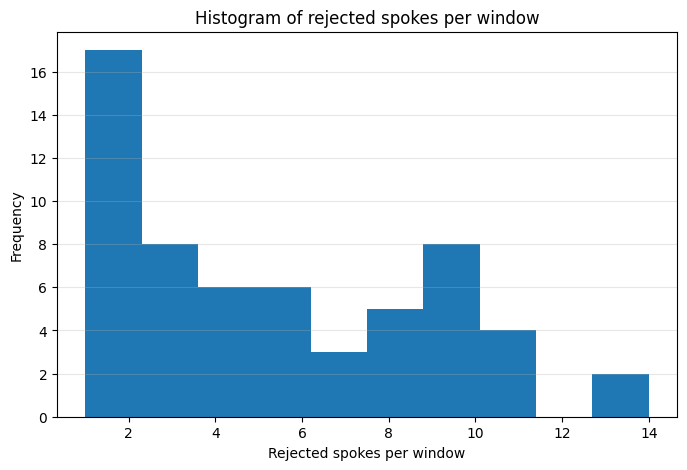

In [14]:
def plot_rejected_histogram(df):
    plt.figure(figsize=(8,5))
    plt.hist(df["afgekeurd_inc_sum"])
    plt.xlabel("Rejected spokes per window")
    plt.ylabel("Frequency")
    plt.title("Histogram of rejected spokes per window")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

plot_rejected_histogram(df_final[df_final["afgekeurd_inc_sum"] > 0])

# Model

In [15]:
def add_future_rejection_count(df, window=6):
    """
    Add target column for regression: rejection count in next horizon_windows.
    df must be aggregated per window already (e.g. 30s window).
    """
    df = df.copy()

    # Future sum of rejections in the next horizon_windows
    df["afgekeurd_next_minute"] = (
        df_final['afgekeurd_inc_sum'].shift(-1).rolling(window, min_periods=1).sum()
    )

    # Drop last rows with unknown future
    df = df.dropna(subset=["afgekeurd_next_minute"])
    return df

def time_series_split(X, y, train_frac=0.7, val_frac=0.15):
    n = len(X)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))

    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]

    X_val = X.iloc[train_end:val_end]
    y_val = y.iloc[train_end:val_end]

    X_test = X.iloc[val_end:]
    y_test = y.iloc[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

def stratified_time_series_split(X, y, test_size=0.2):
    """
    Returns train and test indices for time-series data,
    ensuring both classes are represented in the test set.
    """
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    train_indices = []
    val_indices = []

    for cls in y.unique():
        cls_idx = y[y == cls].index.values
        split = int(len(cls_idx) * (1 - test_size))
        train_indices.extend(cls_idx[:split])
        val_indices.extend(cls_idx[split:])
    
    # Sort indices to preserve time order
    train_indices = sorted(train_indices)
    val_indices = sorted(val_indices)
    
    return train_indices, val_indices

def add_future_rejection_label(df):
    """
    Predict if a rejection will occur in the NEXT horizon_windows.
    
    Example:
    window_seconds = 30
    horizon_windows = 2  -> predicts 60 seconds ahead
    """

    df = df.copy()
    
    # Binary label for current window
    df["rejected_now"] = (df["afgekeurd_inc_sum"] > 0).astype(int)

    # Future label: any rejection in next N windows
    # df["rejected_future"] = (
    #     df["rejected_now"]
    #     .rolling(window=horizon_windows, min_periods=1)
    #     .max()
    #     .shift(-horizon_windows)
    # )

    # Drop last rows with unknown future
    # df = df.dropna(subset=["rejected_future"])
    # df["rejected_future"] = df["rejected_future"].astype(int)

    return df


In [16]:
# 1. Add target
cls_df = add_future_rejection_label(
    df_final
)

# 2. Features & target
TARGET = "rejected_now"
drop_cols = ["TimeInt_first", "TimeStr_first", "afgekeurd_inc_sum", "rejection_rate_current"]
X = cls_df.drop(columns=[TARGET] + drop_cols, errors="ignore")
y = cls_df[TARGET]

# 3. Time-based split
X_train, y_train_clf, X_val, y_val_clf, X_test, y_test_clf = time_series_split(X, y)
train_idx, val_idx = stratified_time_series_split(X_train, y_train_clf, test_size=0.2)
X_train, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
y_train, y_val = y_train_clf.iloc[train_idx], y_train_clf.iloc[val_idx]

In [17]:
# clf = XGBClassifier(
#     objective='binary:logistic',
#     n_estimators=200,
#     max_depth=4,
#     learning_rate=0.1,
#     scale_pos_weight=(len(cls_df[TARGET][cls_df[TARGET] == 0])/len(cls_df[TARGET][cls_df[TARGET] > 0])),
#     eval_metric='aucpr',
#     random_state=42
# )

# clf.fit(
#     X_train,
#     y_train,
#     eval_set=[(X_val, y_val)],
#     verbose=True
# )

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit

# Define parameter grid for XGBClassifier
param_grid_clf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

clf_base = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(len(cls_df[TARGET][cls_df[TARGET] == 0])/len(cls_df[TARGET][cls_df[TARGET] > 0])),
    eval_metric='aucpr',
    random_state=42
)

random_search_clf = RandomizedSearchCV(
    estimator=clf_base,
    param_distributions=param_grid_clf,
    n_iter=100,
    scoring='roc_auc',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

random_search_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)
print("Best clf params:", random_search_clf.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
reg_df = add_future_rejection_count(df_final, window=6)

TARGET = "afgekeurd_next_minute"
drop_cols = ["TimeInt_first", "TimeStr_first", "afgekeurd_inc_sum", "rejection_rate_current"]
X = reg_df.drop(columns=[TARGET] + drop_cols, errors="ignore")
y = reg_df[TARGET]

# 3. Time-based split
X_train, y_train_reg, X_val, y_val_reg, X_test, y_test_reg = time_series_split(X, y)
train_idx, val_idx = stratified_time_series_split(X_train, y_train_reg, test_size=0.2)
X_train, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
y_train, y_val = y_train_reg.iloc[train_idx], y_train_reg.iloc[val_idx]
non_zero_mask = y_train > 0

X_train_nz = X_train.loc[non_zero_mask]
y_train_nz = y_train.loc[non_zero_mask]

X_val_nz = X_val.loc[y_val > 0]
y_val_nz = y_val.loc[y_val > 0]

In [ ]:
# pois = XGBRegressor(
#     objective='count:poisson',
#     n_estimators=300,
#     max_depth=5,
#     learning_rate=0.05,
#     min_child_weight=3,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     eval_metric='poisson-nloglik',
#     random_state=42
# )
# pois.fit(
#     X_train_nz,
#     y_train_nz,
#     eval_set=[(X_val_nz, y_val_nz)],
#     verbose=True
# )

# from xgboost import XGBRegressor
# from sklearn.model_selection import RandomizedSearchCV

param_grid_reg = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

pois_base = XGBRegressor(
    objective='count:poisson',
    eval_metric='poisson-nloglik',
    random_state=42
)

random_search_reg = RandomizedSearchCV(
    estimator=pois_base,
    param_distributions=param_grid_reg,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

random_search_reg.fit(X_train_nz, y_train_nz)
print("Best reg params:", random_search_reg.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best reg params: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [ ]:

p_nonzero = random_search_clf.predict_proba(X_test)[:, 1]
lambda_hat = random_search_reg.predict(X_test)

lambda_hat = np.clip(lambda_hat, 0, None)

y_pred_zip = p_nonzero * lambda_hat
print("Overall MAE:", mean_absolute_error(y_test_reg, y_pred_zip))


Overall MAE: 0.1358743026754966


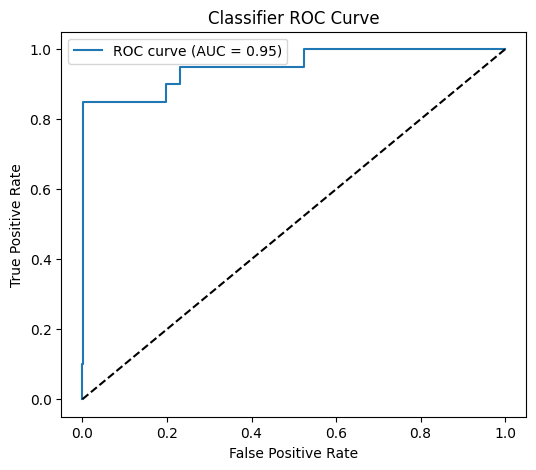

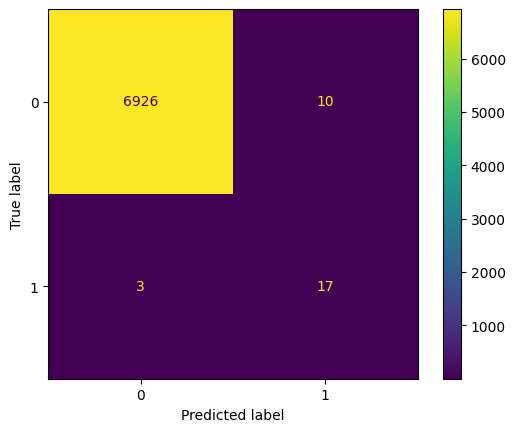

In [ ]:
# ROC Curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_test_clf, p_nonzero)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
y_pred_bin = (p_nonzero > 0.2).astype(int)
cm = confusion_matrix(y_test_clf, y_pred_bin)
ConfusionMatrixDisplay(cm).plot()
plt.show()


In [ ]:
recall_score(y_test_clf, y_pred_bin)

0.85

In [ ]:
for col in X_train.columns:
    clf.fit(X_train[[col]], y_train)
    auc = roc_auc_score(y_test_clf, clf.predict_proba(X_test[[col]])[:,1])
    if auc > 0.9:
        print(col, auc)

StangHistorie_1_.BeginVerduningPosHor_std 0.9065275374855825
StangHistorie_1_.EindVerduningPos_std 0.9256379757785468
StangHistorie_1_.EindVerduningPosHor_std 0.9231833910034603


In [ ]:
# # Create SHAP explainer for classifier
# explainer_clf = shap.TreeExplainer(clf)
# shap_values_clf = explainer_clf.shap_values(X_test)

# # Summary plot
# shap.summary_plot(shap_values_clf, X_test, plot_type="bar", max_display=20, show=True)

# # Optional: detailed beeswarm plot
# shap.summary_plot(shap_values_clf, X_test, plot_type="dot", max_display=20, show=True)

# # Explain a single example
# i = 0  # index of test row
# shap.force_plot(explainer_clf.expected_value, shap_values_clf[i], X_test.iloc[i])


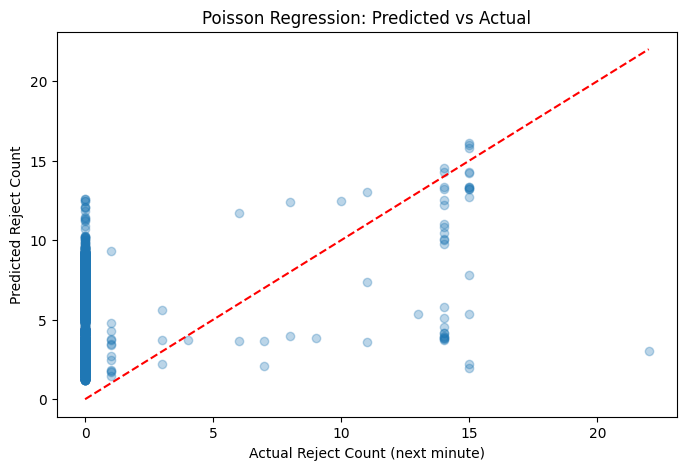

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(y_test_reg, lambda_hat, alpha=0.3)
plt.plot([0, max(y_test_reg)], [0, max(y_test_reg)], 'r--')  # perfect prediction line
plt.xlabel('Actual Reject Count (next minute)')
plt.ylabel('Predicted Reject Count')
plt.title('Poisson Regression: Predicted vs Actual')
plt.show()


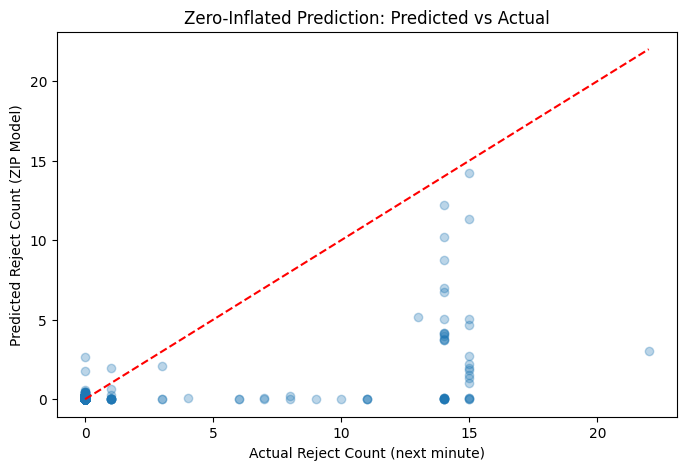

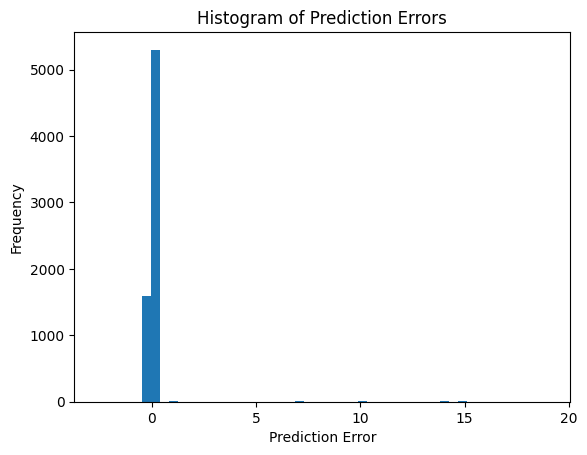

In [ ]:
y_hat_zip = p_nonzero * lambda_hat

plt.figure(figsize=(8,5))
plt.scatter(y_test_reg, y_hat_zip, alpha=0.3)
plt.plot([0, max(y_test_reg)], [0, max(y_test_reg)], 'r--')
plt.xlabel('Actual Reject Count (next minute)')
plt.ylabel('Predicted Reject Count (ZIP Model)')
plt.title('Zero-Inflated Prediction: Predicted vs Actual')
plt.show()

# Optional: histogram of errors
errors = y_test_reg - y_hat_zip
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


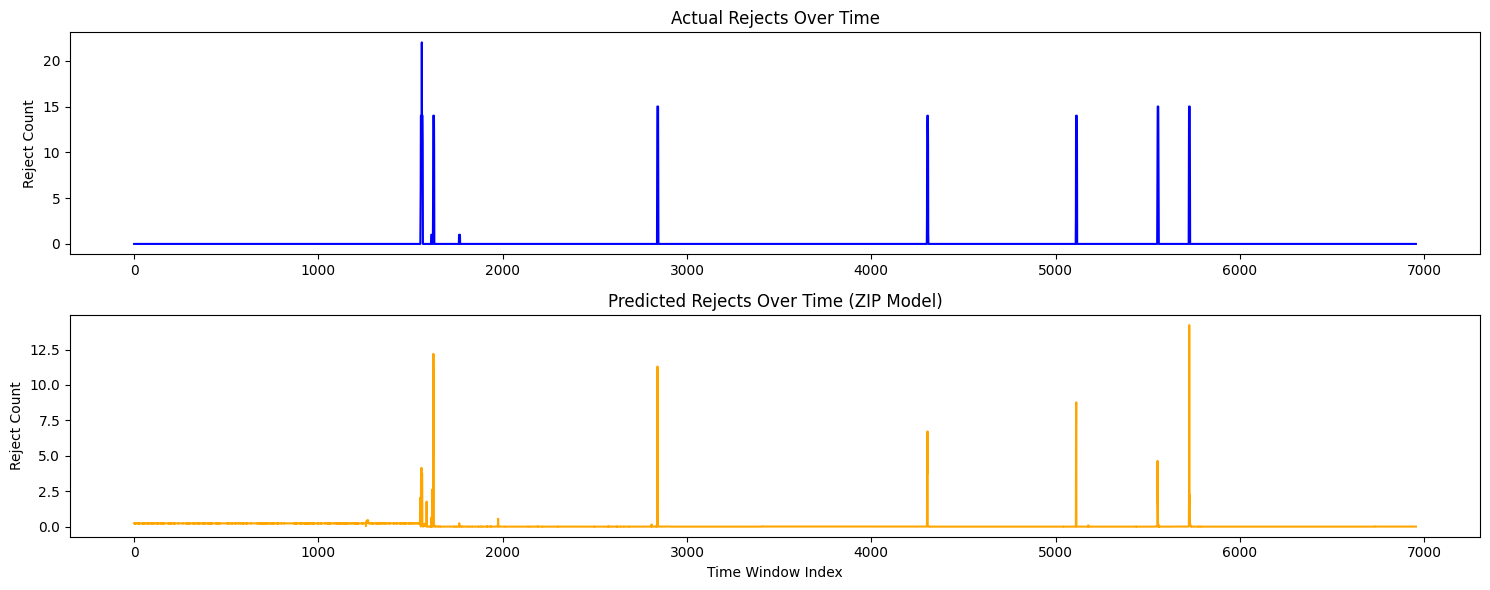

In [ ]:

plt.figure(figsize=(15,6))

# Subplot 1: Actual rejects
plt.subplot(2, 1, 1)
plt.plot(y_test_reg.values, color='blue')
plt.title('Actual Rejects Over Time')
plt.ylabel('Reject Count')

# Subplot 2: Predicted rejects (ZIP)
plt.subplot(2, 1, 2)
plt.plot(y_hat_zip, color='orange')
plt.title('Predicted Rejects Over Time (ZIP Model)')
plt.xlabel('Time Window Index')
plt.ylabel('Reject Count')

plt.tight_layout()
plt.show()

# Baseline

In [ ]:
# 4. Random Forest regression baseline
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)

print("RF Validation:")
print("MAE:", mean_absolute_error(y_val, y_val_pred))
print("R2:", r2_score(y_val, y_val_pred))

RF Validation:
MAE: 0.025049583788650256
R2: 0.7672199796177855


In [ ]:
mask = y_val > 0
mask_test = y_test > 0

print(f"MAE for rejection cases:\n{mean_absolute_error(y_val[mask], y_val_pred[mask])}")

MAE for rejection cases:
3.6167345519608163


In [ ]:

# 5. XGBoost regression baseline
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective = "count:poisson",
    eval_metric = "poisson-nloglik",
    random_state=42
)

xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
y_val_pred_xgb = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

# Ensure numerical stability
y_pred_test = np.clip(y_pred_test, 0, None)

print("XGB Validation:")
print("MAE:", mean_absolute_error(y_val, y_val_pred_xgb))
print("R2:", r2_score(y_val, y_val_pred_xgb))

XGB Validation:
MAE: 0.030632868324379076
R2: 0.5855175813885012


In [ ]:
mask = y_val > 0

print(f"MAE for rejection cases:\n{mean_absolute_error(y_val[mask], y_val_pred_xgb[mask])}")

MAE for rejection cases:
5.425605164737806


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'n_estimators': [100, 200, 300, 400], 'max_depth': [3, 4, 5, 6], 'learning_rate': [0.05, 0.1, 0.2]
              }
grid_search = GridSearchCV(XGBRegressor(objective="reg:pseudohubererror", random_state=42), param_grid, cv=tscv)
grid_search.fit(X, y)

KeyboardInterrupt: 

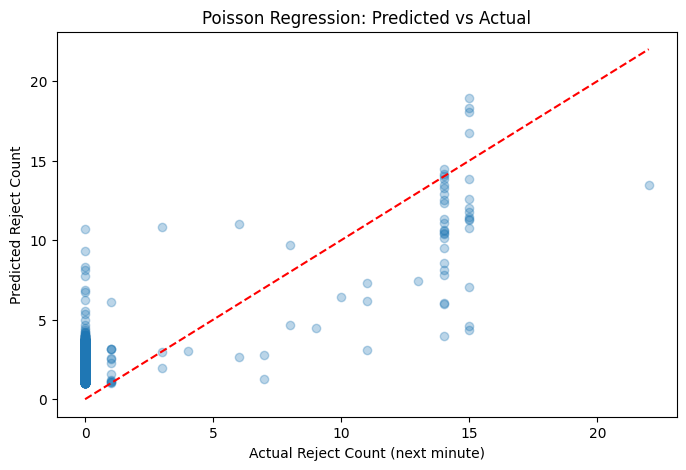

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, lambda_hat, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel('Actual Reject Count (next minute)')
plt.ylabel('Predicted Reject Count')
plt.title('Poisson Regression: Predicted vs Actual')
plt.show()


# VISUALIZE

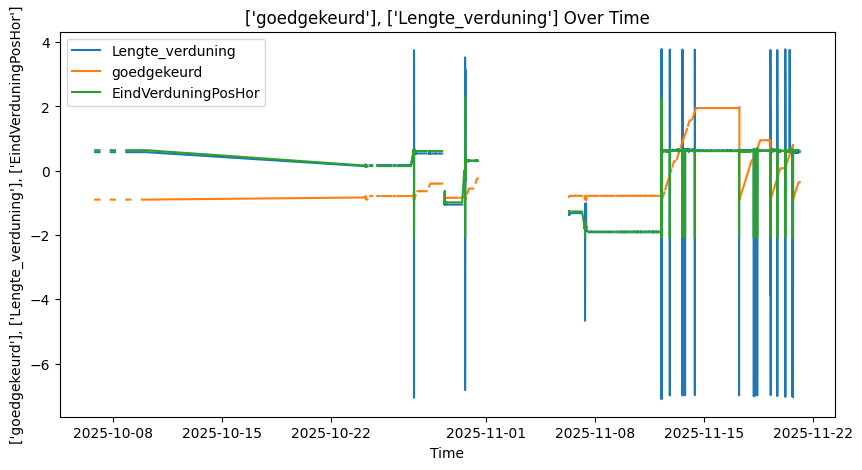

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

ss = SVRM3_ewon_df_cleaned.copy()
sc = StandardScaler()
ss['goedgekeurd'] = sc.fit_transform(ss[['goedgekeurd']])
ss['Lengte_verduning'] = sc.fit_transform(ss[['Lengte_verduning']])
ss['EindVerduningPosHor'] = sc.fit_transform(ss[['EindVerduningPosHor']])

y_label = ["goedgekeurd"]
y_label_2 = ["Lengte_verduning"]
y_label_3 = ["EindVerduningPosHor"]

plt.figure(figsize=(10, 5))

plt.plot(ss['TimeStr'], ss[y_label_2])
plt.plot(ss['TimeStr'], ss[y_label])
plt.plot(ss['TimeStr'], ss[y_label_3])
plt.xlabel('Time')
plt.ylabel(f"{y_label}, {y_label_2}, {y_label_3}")
plt.title(f'{y_label}, {y_label_2} Over Time')
plt.legend(['Lengte_verduning', 'goedgekeurd', 'EindVerduningPosHor'])
plt.show()

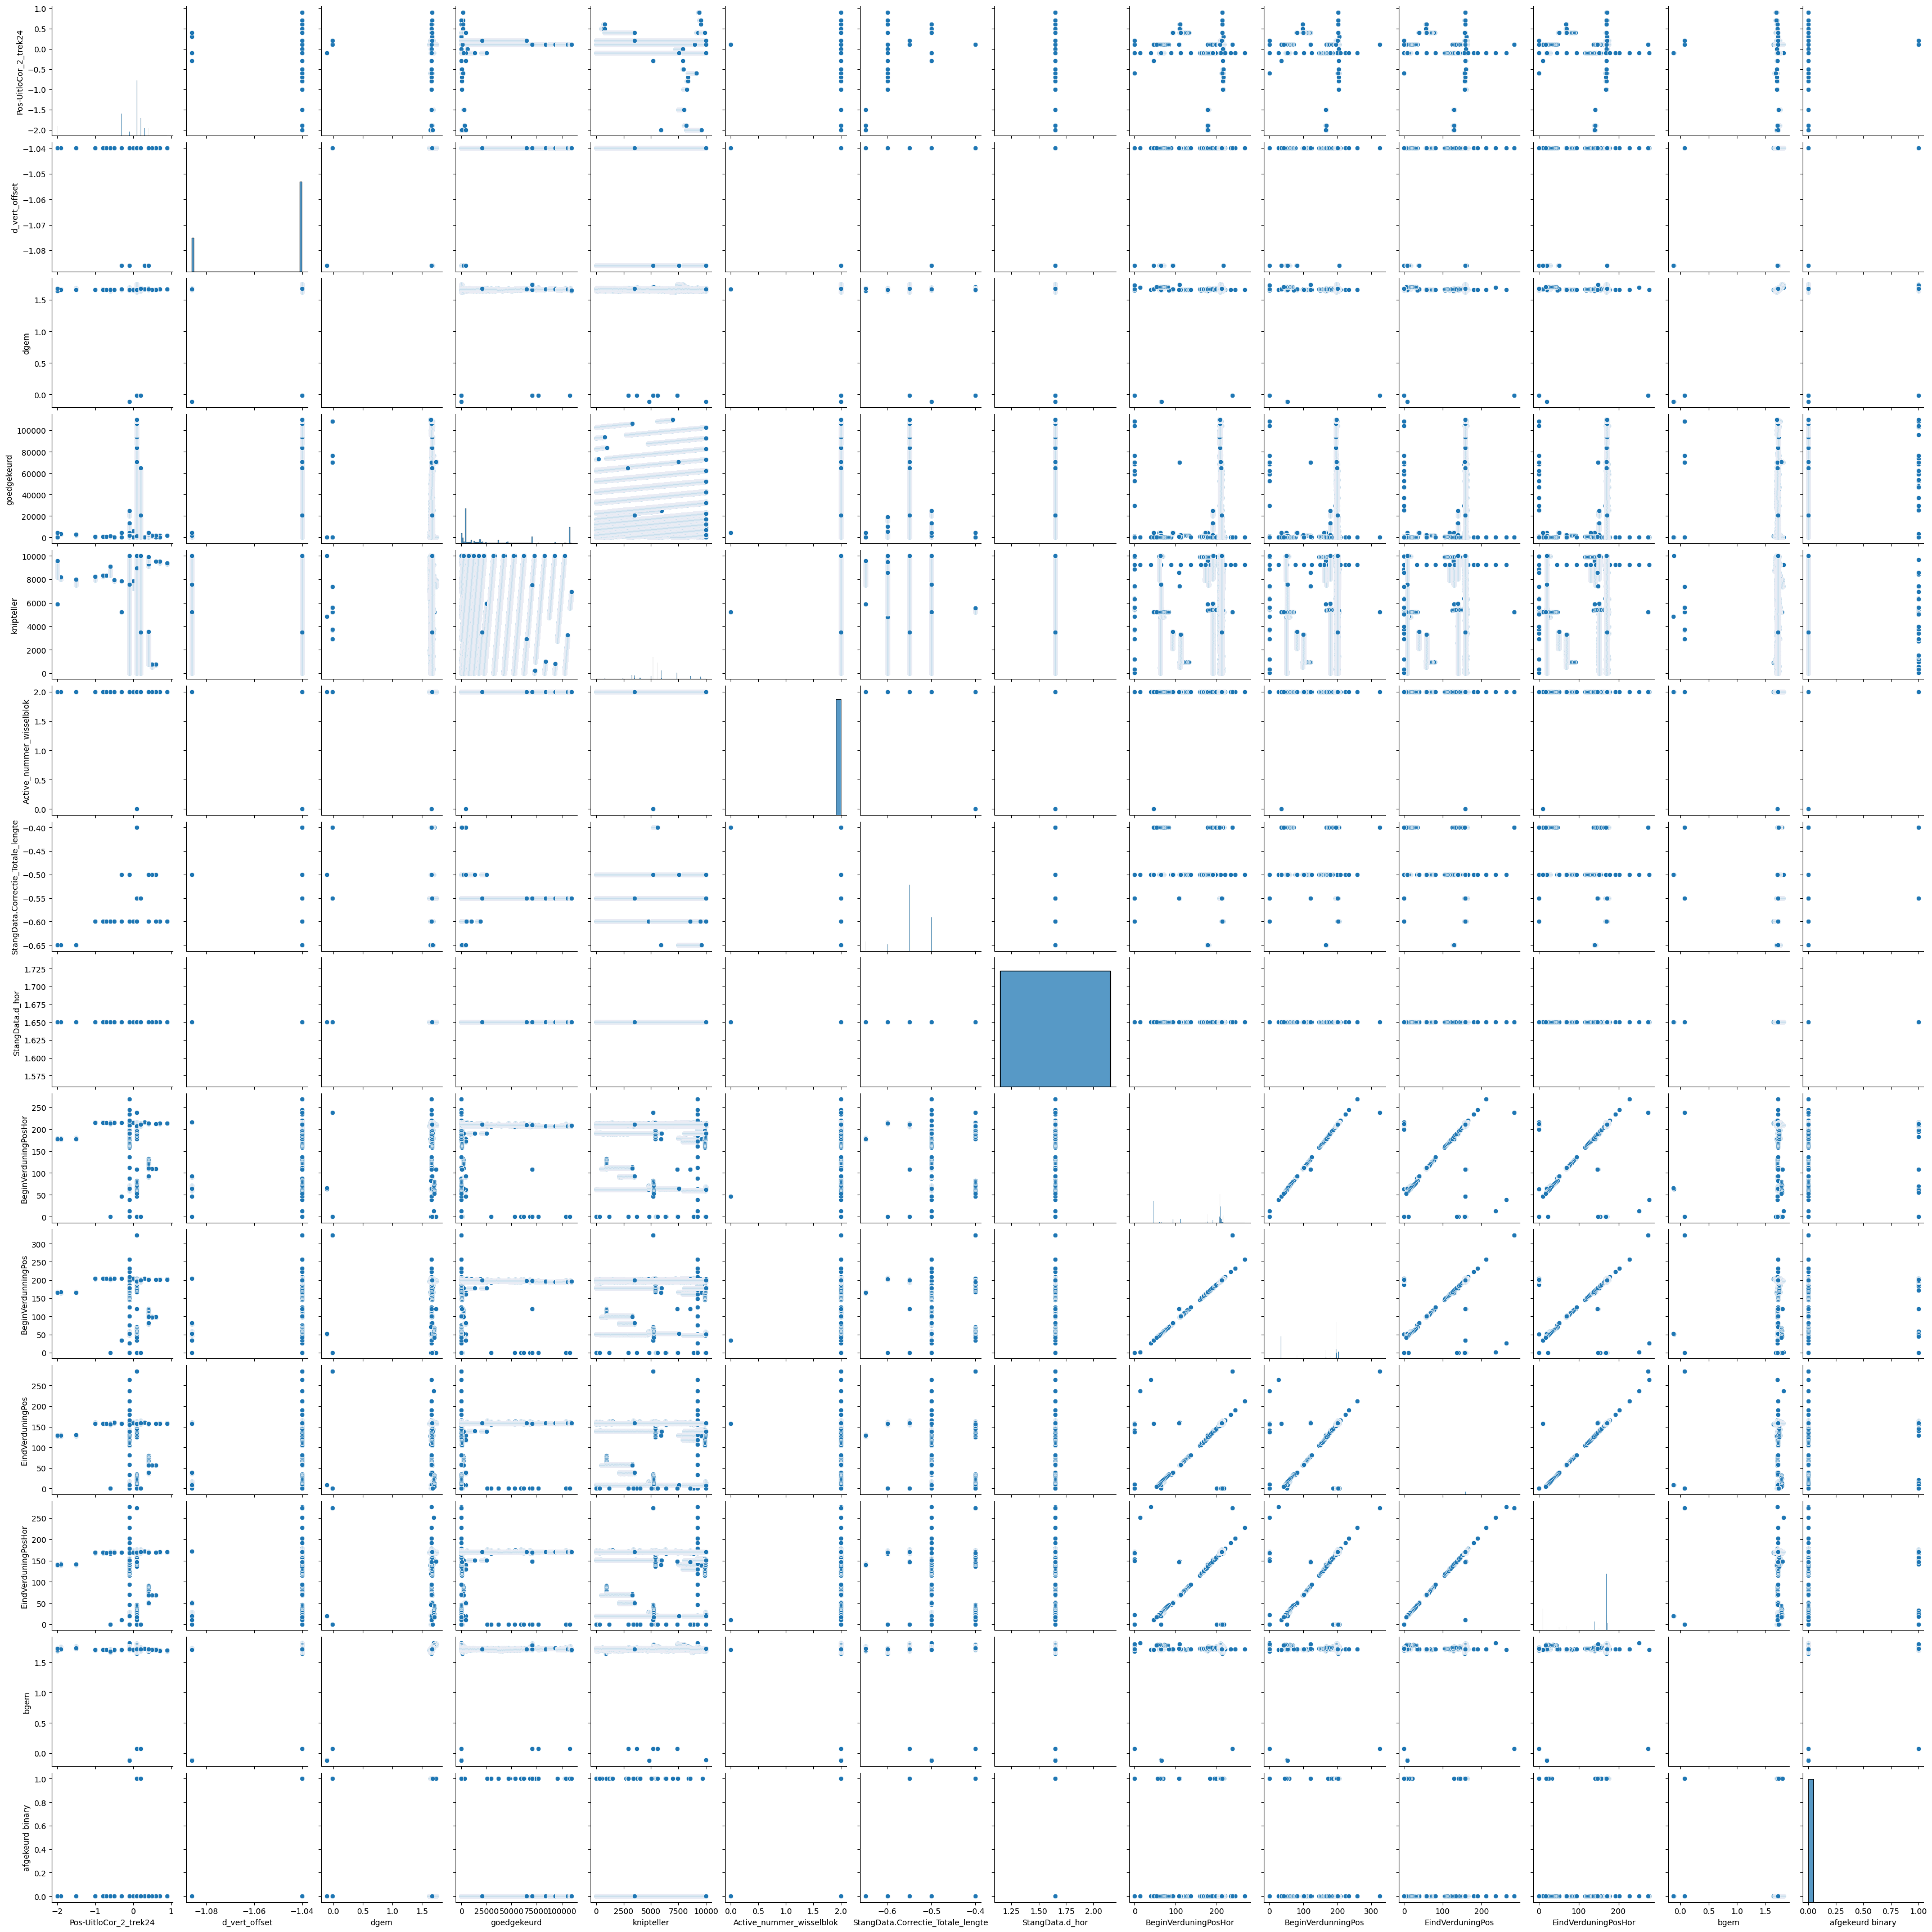

In [ ]:
seaborn.pairplot(SVRM3_ewon_df_cleaned[[
"dgem",
"goedgekeurd",
"knipteller",
"Active_nummer_wisselblok",
"StangData.Correctie_Totale_lengte",
"StangData.d_hor",
"BeginVerduningPosHor",
"BeginVerdunningPos",
"EindVerduningPos",
"EindVerduningPosHor",
"bgem",
"afgekeurd binary"]])

plt.show()

<Axes: >

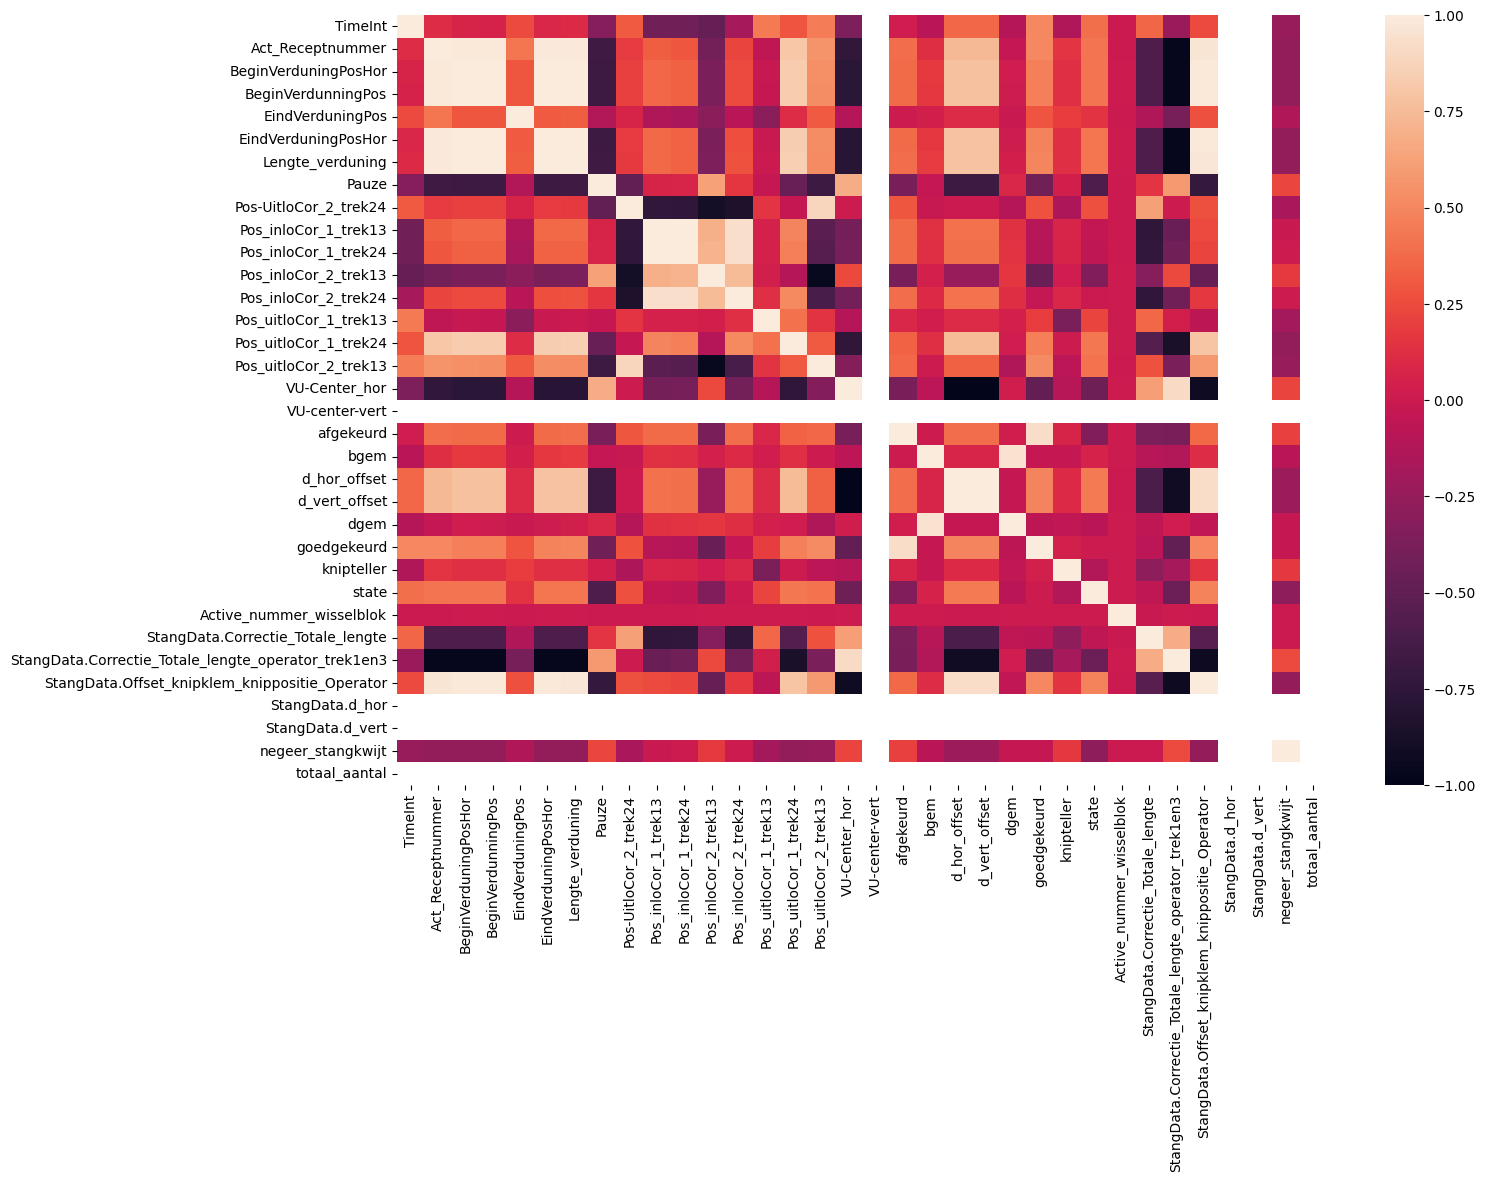

In [ ]:
matrix = SVRM3_ewon_df_cleaned.corr(numeric_only=True)
plt.figure(figsize=(15, 10)) 
seaborn.heatmap(matrix)

In [ ]:
SVRM3_ewon_df_cleaned["goedgekeurd"]

1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
            ...   
1117918    20558.0
1117919    20558.0
1117920    20558.0
1117921    20558.0
1117922    20558.0
Name: goedgekeurd, Length: 820690, dtype: float64

In [ ]:
# ensure numeric
SVRM3_ewon_df_cleaned['afgekeurd'] = pd.to_numeric(SVRM3_ewon_df_cleaned['afgekeurd'], errors='coerce')

# forward fill for reference
afgekeurd_ffill = SVRM3_ewon_df_cleaned['afgekeurd'].ffill()

# last valid afgekeurd
last_valid = afgekeurd_ffill.shift(1)

# delta calculation
SVRM3_ewon_df_cleaned['delta'] = SVRM3_ewon_df_cleaned['afgekeurd'] - last_valid

# handle resets
SVRM3_ewon_df_cleaned.loc[SVRM3_ewon_df_cleaned['delta'] < 0, 'delta'] = SVRM3_ewon_df_cleaned['afgekeurd']

SVRM3_ewon_df_cleaned["afgekeurd binary"] = (SVRM3_ewon_df_cleaned["delta"].notna() & SVRM3_ewon_df_cleaned["delta"] != 0).astype(int)
# SVRM3_ewon_df_cleaned.drop(columns=['delta'], inplace=True)


# CORRELATION

In [ ]:
# SVRM3_ewon_df_cleaned[SVRM3_ewon_df_cleaned["afgekeurd binary"] == 1]

SHAP values computed for XGBoost
Shape of SHAP values: (164138, 32)

XGBoost Feature Importance (SHAP):
                                              feature  mean_abs_shap
24                                              state       0.961048
1                                BeginVerduningPosHor       0.941233
17                                          afgekeurd       0.871365
3                                    EindVerduningPos       0.505195
4                                 EindVerduningPosHor       0.448482
23                                         knipteller       0.349206
18                                               bgem       0.286145
31                                  negeer_stangkwijt       0.236047
21                                               dgem       0.233812
5                                    Lengte_verduning       0.215811
22                                        goedgekeurd       0.194131
2                                  BeginVerdunningPos       0.132132

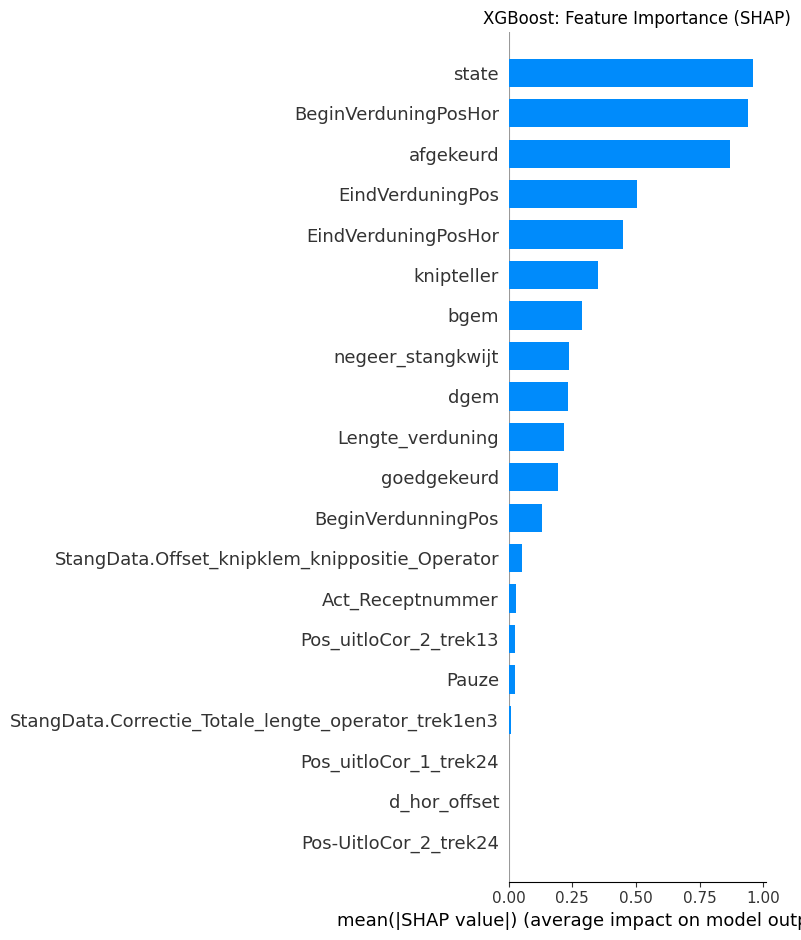

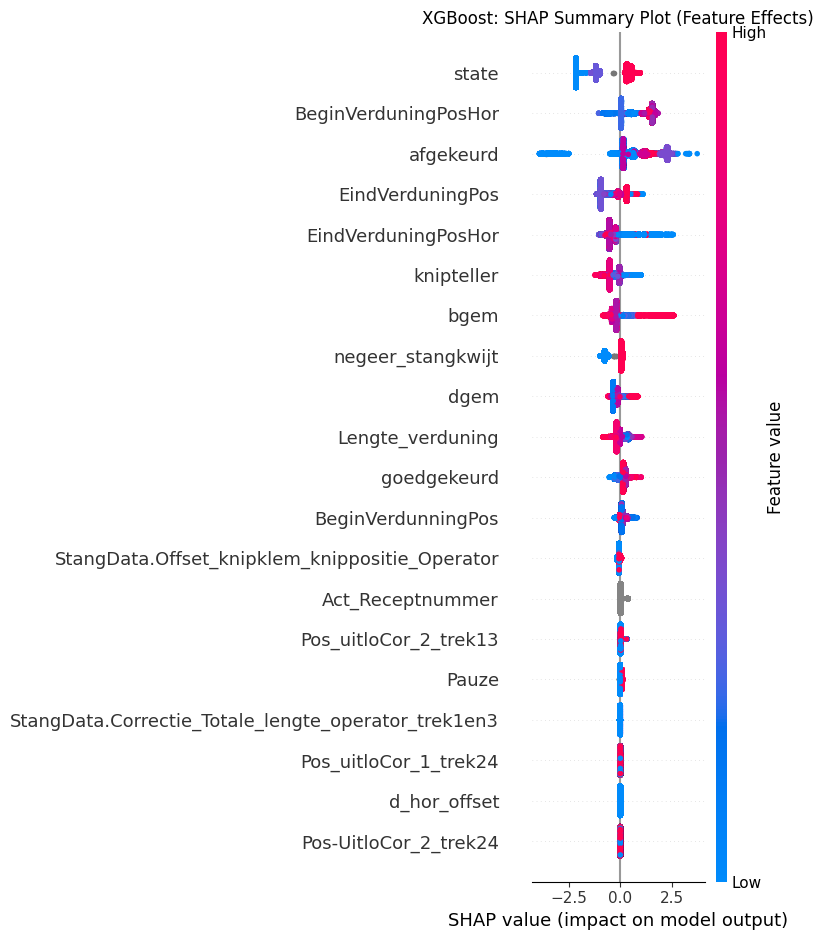

In [ ]:
X = df.iloc[:, 2:-3]
y = df["afgekeurd binary"]

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
import lightgbm as lgb
import shap


# Time-based split
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Create SHAP explainer for XGBoost (TreeExplainer is fast for tree models)
explainer_xgb = shap.TreeExplainer(model)

# Calculate SHAP values for test set
shap_values_xgb = explainer_xgb.shap_values(X_test)

print("SHAP values computed for XGBoost")
print(f"Shape of SHAP values: {shap_values_xgb.shape}")

# Feature importance based on mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_values_xgb).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print("\nXGBoost Feature Importance (SHAP):")
print(shap_importance)

# Visualizations for XGBoost
print("\nGenerating XGBoost SHAP plots...")

# Summary plot (bar) - feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.title("XGBoost: Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# Summary plot (beeswarm) - shows feature effects
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_xgb, X_test, show=False)
plt.title("XGBoost: SHAP Summary Plot (Feature Effects)")
plt.tight_layout()
plt.show()

In [ ]:
df.columns[-3]

'totaal_aantal'

In [ ]:
SVRM3_ewon_df_cleaned.info()

In [ ]:
names = SVRM3_ewon_df_cleaned.columns[2:]
for name, importance in zip(names, importances):
    if importance > 0:
       print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: BeginVerduningPosHor, Importance: 4.12
Feature: Lengte_verduning, Importance: 0.88
Feature: Pos-UitloCor_2_trek24, Importance: 6.54
Feature: Pos_inloCor_1_trek13, Importance: 2.93
Feature: Pos_inloCor_1_trek24, Importance: 0.06
Feature: Pos_inloCor_2_trek13, Importance: 3.85
Feature: Pos_uitloCor_1_trek13, Importance: 9.41
Feature: Pos_uitloCor_1_trek24, Importance: 1.33
Feature: Pos_uitloCor_2_trek13, Importance: 1.25
Feature: bgem, Importance: 4.57
Feature: dgem, Importance: 3.24
Feature: goedgekeurd, Importance: 4.34
Feature: knipteller, Importance: 25.75
Feature: state, Importance: 0.89
Feature: StangData.Correctie_Totale_lengte, Importance: 3.34
Feature: StangData.Correctie_Totale_lengte_operator_trek1en3, Importance: 0.14
Feature: StangData.Offset_knipklem_knippositie_Operator, Importance: 0.55
Feature: Wisselblok_settings[2].Wp1_diameter_offset, Importance: 11.41
Feature: Wisselblok_settings[2].Wp2_diameter_offset, Importance: 7.78
Feature: afgekeurd binary, Importance:

In [ ]:
for lag in range(1, 11):
    SVRM3_ewon_df_cleaned[[f"{col}_lag{lag}" for col in X]] = SVRM3_ewon_df_cleaned[X].shift(lag)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

mi = mutual_info_classif(X_imp, y, random_state=42)

KeyboardInterrupt: 

In [ ]:
SVRM3_ewon_df_cleaned.dtypes[SVRM3_ewon_df_cleaned.dtypes != "float64"]

TimeInt                                                         int64
TimeStr                                                datetime64[ns]
Act_Receptnummer                                               object
BeginVerduningPosHor                                           object
BeginVerdunningPos                                             object
EindVerduningPos                                               object
EindVerduningPosHor                                            object
Lengte_verduning                                               object
Pauze                                                          object
Pos-UitloCor_2_trek24                                          object
Pos_inloCor_1_trek13                                           object
Pos_inloCor_1_trek24                                           object
Pos_inloCor_2_trek13                                           object
Pos_inloCor_2_trek24                                           object
Pos_uitloCor_1_trek1

In [ ]:
SVRM3_ewon_df_cleaned.columns

Index(['TimeInt', 'TimeStr', 'Act_Receptnummer', 'BeginVerduningPosHor',
       'BeginVerdunningPos', 'EindVerduningPos', 'EindVerduningPosHor',
       'Lengte_verduning', 'Pauze', 'Pos-UitloCor_2_trek24',
       'Pos_inloCor_1_trek13', 'Pos_inloCor_1_trek24', 'Pos_inloCor_2_trek13',
       'Pos_inloCor_2_trek24', 'Pos_uitloCor_1_trek13',
       'Pos_uitloCor_1_trek24', 'Pos_uitloCor_2_trek13', 'VU-Center_hor',
       'VU-center-vert', 'afgekeurd', 'bgem', 'd_hor_offset', 'd_vert_offset',
       'dgem', 'goedgekeurd', 'knipteller', 'state',
       'Active_nummer_wisselblok', 'StangData.Correctie_Totale_lengte',
       'StangData.Correctie_Totale_lengte_operator_trek1en3',
       'StangData.Offset_knipklem_knippositie_Operator', 'StangData.d_hor',
       'StangData.d_vert', 'Wisselblok_settings[2].Wp1_diameter_offset',
       'Wisselblok_settings[2].Wp1_hartlijn_offset',
       'Wisselblok_settings[2].Wp2_diameter_offset',
       'Wisselblok_settings[2].Wp2_hartlijn_offset',
       'Wis

# Model

ISOLATION FOREST TESTING PIPELINE

[1/6] Preparing data...
Features selected: 7
Good production samples: 529467 (64.5%)
Samples with upcoming rejection: 663 (0.1%)

[2/6] Splitting data (time-based)...
  Training samples (good production only): 365998
  Validation samples: 131311 (rejection rate: 0.1%)
  Test samples: 164138 (rejection rate: 0.2%)

[3/6] Training Isolation Forest...

Training Isolation Forest...
  Training samples: 365998
  Features: 7
  Contamination: auto


C:\Users\ravin\AppData\Local\Temp\ipykernel_20032\3157367579.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_features = X_features.fillna(method='bfill').fillna(0)


✓ Training complete

[4/6] Optimizing threshold...

Finding optimal threshold to maximize f1...
✓ Optimal threshold: -0.5585
  Best f1: 0.151

[5/6] Evaluating on test set...

Evaluating model...

ISOLATION FOREST PERFORMANCE
Precision:  0.003 (of flagged alerts, how many were real)
Recall:     0.880 (of real rejections, how many we caught)
F1 Score:   0.005 (harmonic mean)
ROC-AUC:    0.753
Avg Precision: 0.076

Confusion Matrix:
  True Negatives:   72577 (correct normal predictions)
  False Positives:  91294 (false alarms)
  False Negatives:     32 (missed rejections)
  True Positives:     235 (caught rejections)

Practical Metrics:
  False Alarm Rate: 55.7% (alerts during normal production)
  Miss Rate:        12.0% (rejections we didn't catch)

[6/6] Creating visualizations...


C:\Users\ravin\AppData\Local\Temp\ipykernel_20032\3157367579.py:330: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Normal', 'Rejection'], patch_artist=True)


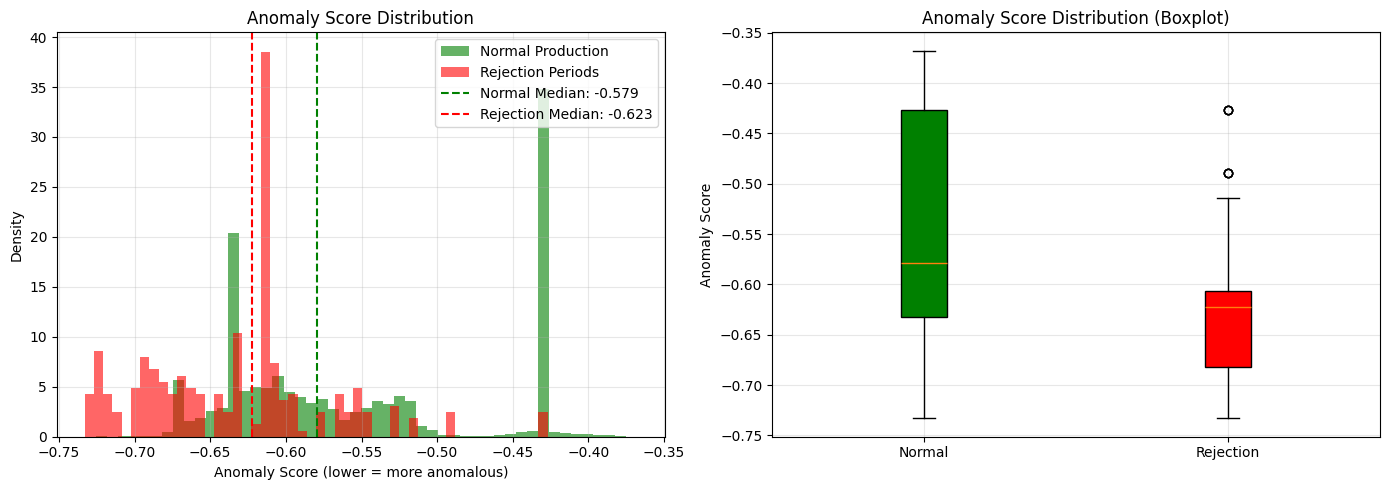


Anomaly Score Statistics:
  Normal Production:
    Mean: -0.5520, Std: 0.0871
    Median: -0.5792
  Rejection Periods:
    Mean: -0.6332, Std: 0.0603
    Median: -0.6227
  Separation: 0.93 std devs


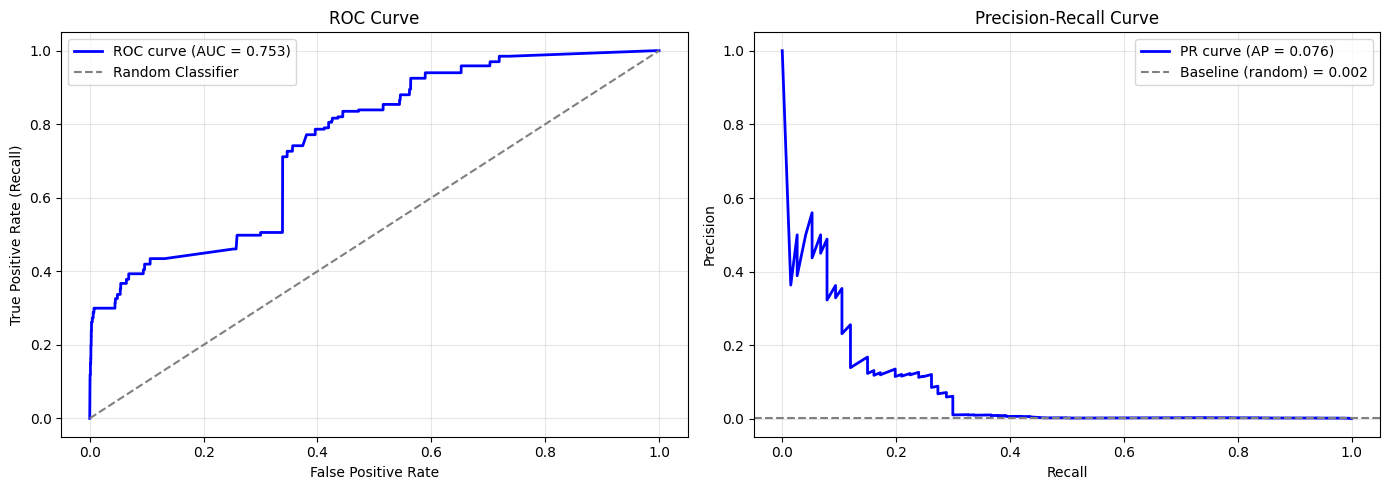

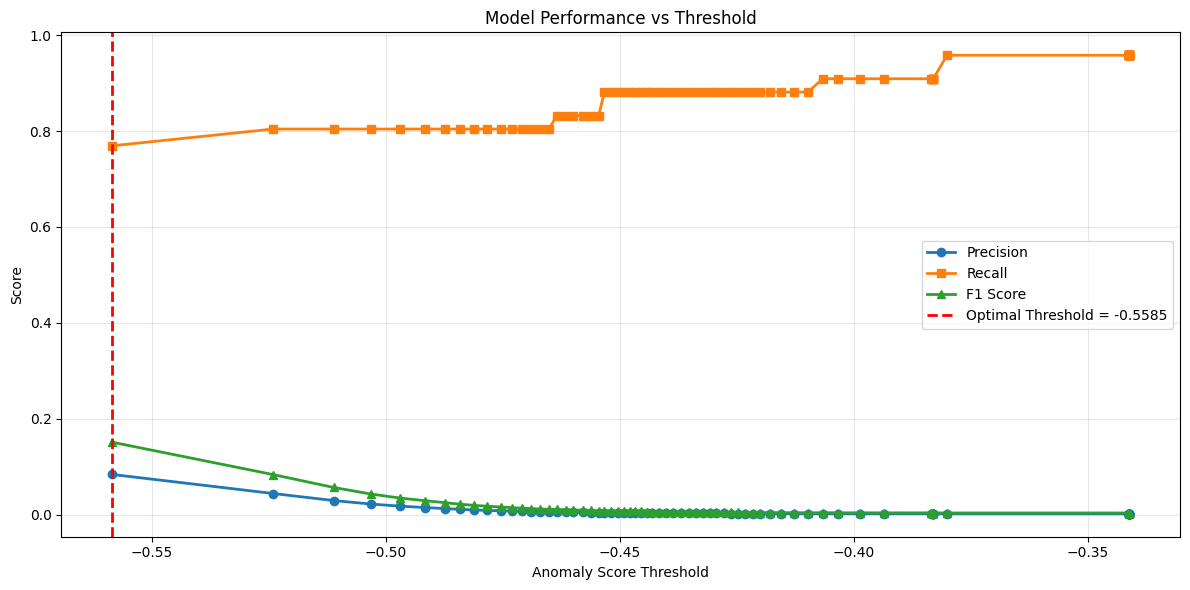

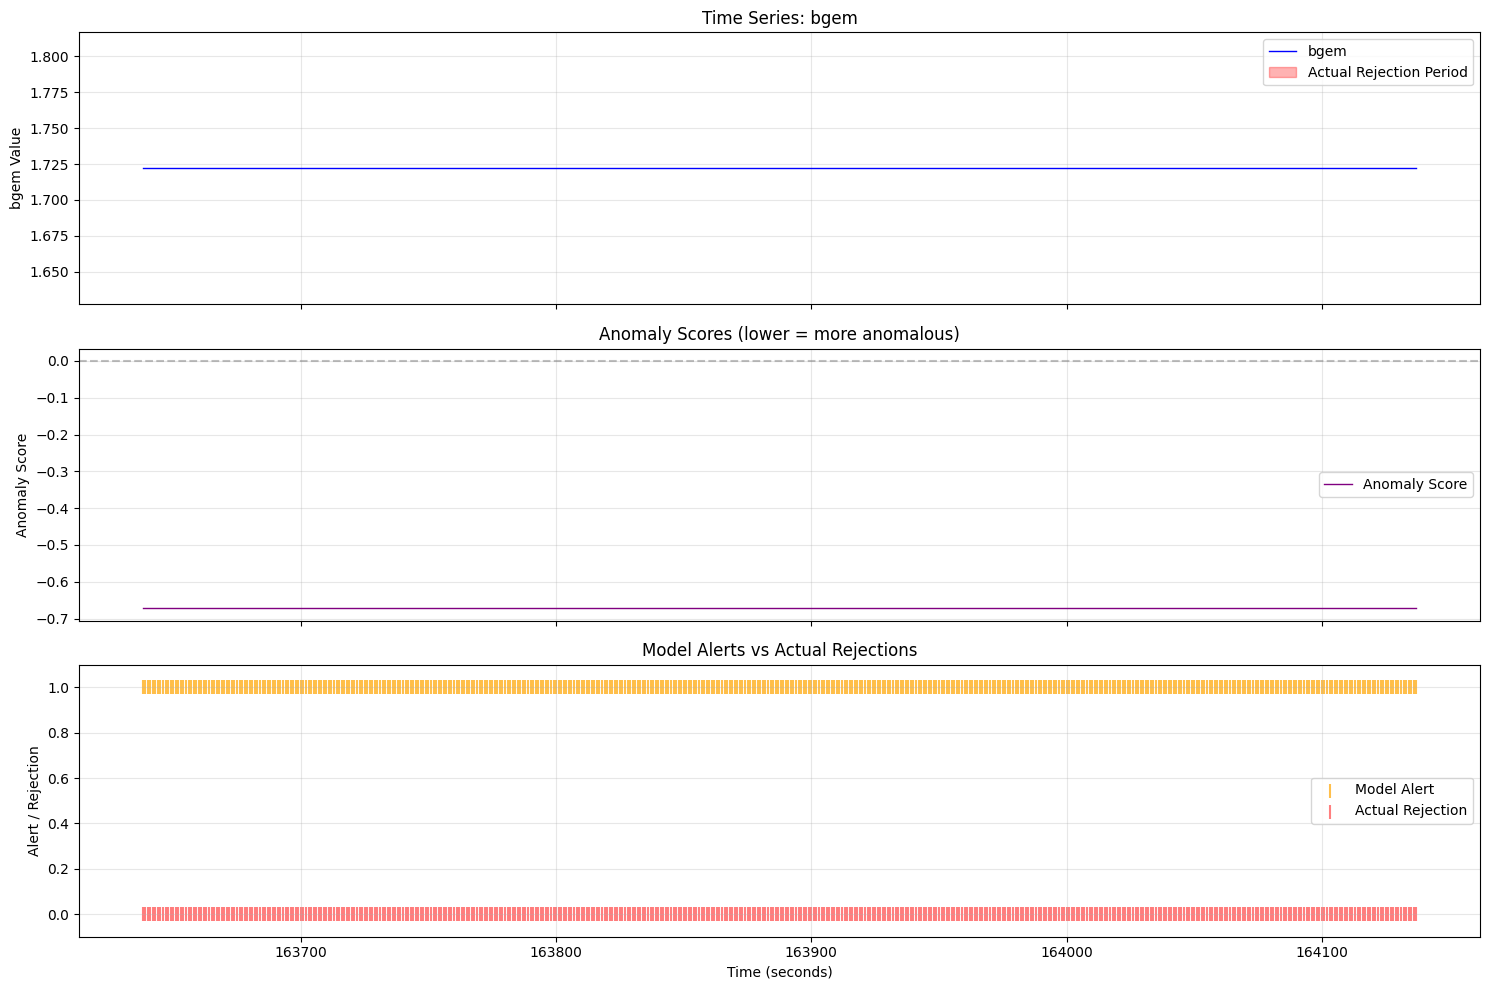


TESTING COMPLETE

Final Model Performance:
  Precision: 0.003
  Recall: 0.880
  F1 Score: 0.005
  ROC-AUC: 0.753


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
import seaborn as sns

# ==========================================
# STEP 1: PREPARE DATA
# ==========================================

def prepare_data_for_anomaly_detection(df, forecast_horizon=50):
    """
    Prepare data for anomaly detection approach.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with engineered features
    forecast_horizon : int
        How many seconds ahead to predict (default: 5)
    
    Returns:
    --------
    X_features : pd.DataFrame
        Feature matrix (volatility features)
    y_target : pd.Series
        Binary target (1 = rejection will occur, 0 = normal)
    good_production_mask : pd.Series
        Boolean mask for "good" production periods (for training anomaly detector)
    """
    
    # Create binary target: Will rejection occur in next N seconds?
    if 'afgekeurd_inc' in df.columns:
        # Option A: Binary - any rejection in next N seconds
        y_target = (df['afgekeurd_inc'].rolling(forecast_horizon).sum().shift(-forecast_horizon) > 0).astype(int)
    else:
        raise ValueError("Column 'afgekeurd_inc' not found in dataframe")
    
    # Define "good production" (for training the anomaly detector)
    # Option 1: No rejections in past 30s or next 10s (very conservative)
    past_rejections = df['afgekeurd_inc'].rolling(30, min_periods=1).sum()
    future_rejections = df['afgekeurd_inc'].rolling(10).sum().shift(-10)
    good_production_mask = (past_rejections == 0) & (future_rejections == 0)
    
    # Select volatility features only (these are your strongest signals)
    volatility_cols = [col for col in df.columns if any(
        keyword in col for keyword in ['_std_', '_range_', '_cv_', '_iqr_', 
                                        'combined_volatility', 'max_volatility']
    )]
    
    # Also include critical raw parameters
    critical_params = ['StangHistorie[1].BeginVerduningPosHor',
       'StangHistorie[1].BeginVerdunningPos',
       'StangHistorie[1].EindVerduningPos',
       'StangHistorie[1].EindVerduningPosHor', 'StangHistorie[1].L_v',
       'StangHistorie[1].bgem', 'StangHistorie[1].dgem']
    
    raw_cols = [col for col in df.columns if any(param in col for param in critical_params)]
    
    # Combine
    feature_cols = list(set(volatility_cols + raw_cols))
    
    if len(feature_cols) == 0:
        raise ValueError("No volatility features found. Did you run add_volatility_features()?")
    
    X_features = df[feature_cols].copy()
    
    # Handle NaN (from rolling windows at the start)
    X_features = X_features.fillna(method='bfill').fillna(0)
    
    print(f"Features selected: {len(feature_cols)}")
    print(f"Good production samples: {good_production_mask.sum()} ({good_production_mask.sum()/len(df)*100:.1f}%)")
    print(f"Samples with upcoming rejection: {y_target.sum()} ({y_target.sum()/len(df)*100:.1f}%)")
    
    return X_features, y_target, good_production_mask


# ==========================================
# STEP 2: TRAIN ISOLATION FOREST
# ==========================================

def train_isolation_forest(X_train, contamination='auto', n_estimators=100, random_state=42):
    """
    Train Isolation Forest on "good production" data only.
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features (should be ONLY good production samples)
    contamination : float or 'auto'
        Expected proportion of outliers (default: 'auto')
        If you know ~5% of samples are anomalies, use contamination=0.05
    n_estimators : int
        Number of trees in the forest
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    model : IsolationForest
        Trained model
    """
    
    print(f"\nTraining Isolation Forest...")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Features: {X_train.shape[1]}")
    print(f"  Contamination: {contamination}")
    
    model = IsolationForest(
        contamination=contamination,
        n_estimators=n_estimators,
        max_samples='auto',
        random_state=random_state,
        n_jobs=-1  # Use all CPU cores
    )
    
    model.fit(X_train)
    
    print(f"✓ Training complete")
    
    return model


# ==========================================
# STEP 3: EVALUATE MODEL
# ==========================================

def evaluate_isolation_forest(model, X_test, y_test, threshold=None):
    """
    Evaluate Isolation Forest performance.
    
    Parameters:
    -----------
    model : IsolationForest
        Trained model
    X_test : pd.DataFrame
        Test features
    y_test : pd.Series
        True labels (1 = rejection, 0 = normal)
    threshold : float, optional
        Custom threshold for anomaly score. If None, uses model's default.
    
    Returns:
    --------
    results : dict
        Dictionary with evaluation metrics and predictions
    """
    
    print(f"\nEvaluating model...")
    
    # Get anomaly scores (lower = more anomalous)
    anomaly_scores = model.score_samples(X_test)
    
    # Get predictions (-1 = anomaly, 1 = normal)
    predictions_raw = model.predict(X_test)
    
    # Convert to binary (1 = anomaly/rejection, 0 = normal)
    predictions = (predictions_raw == -1).astype(int)
    
    # If custom threshold provided, override predictions
    if threshold is not None:
        predictions = (anomaly_scores < threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1 = f1_score(y_test, predictions, zero_division=0)
    
    # ROC-AUC (use negative scores because lower = more anomalous)
    try:
        roc_auc = roc_auc_score(y_test, -anomaly_scores)
        avg_precision = average_precision_score(y_test, -anomaly_scores)
    except:
        roc_auc = None
        avg_precision = None
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    # Print results
    print(f"\n{'='*50}")
    print(f"ISOLATION FOREST PERFORMANCE")
    print(f"{'='*50}")
    print(f"Precision:  {precision:.3f} (of flagged alerts, how many were real)")
    print(f"Recall:     {recall:.3f} (of real rejections, how many we caught)")
    print(f"F1 Score:   {f1:.3f} (harmonic mean)")
    if roc_auc:
        print(f"ROC-AUC:    {roc_auc:.3f}")
        print(f"Avg Precision: {avg_precision:.3f}")
    
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives:  {tn:>6} (correct normal predictions)")
    print(f"  False Positives: {fp:>6} (false alarms)")
    print(f"  False Negatives: {fn:>6} (missed rejections)")
    print(f"  True Positives:  {tp:>6} (caught rejections)")
    
    # Calculate practical metrics
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    miss_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    print(f"\nPractical Metrics:")
    print(f"  False Alarm Rate: {false_alarm_rate:.1%} (alerts during normal production)")
    print(f"  Miss Rate:        {miss_rate:.1%} (rejections we didn't catch)")
    
    results = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'confusion_matrix': cm,
        'predictions': predictions,
        'anomaly_scores': anomaly_scores,
        'false_alarm_rate': false_alarm_rate,
        'miss_rate': miss_rate
    }
    
    return results


# ==========================================
# STEP 4: FIND OPTIMAL THRESHOLD
# ==========================================

def find_optimal_threshold(model, X_val, y_val, metric='f1'):
    """
    Find optimal anomaly score threshold to maximize a chosen metric.
    
    Parameters:
    -----------
    model : IsolationForest
        Trained model
    X_val : pd.DataFrame
        Validation features
    y_val : pd.Series
        True labels
    metric : str
        Metric to optimize ('f1', 'recall', 'precision')
    
    Returns:
    --------
    optimal_threshold : float
        Best threshold value
    best_score : float
        Best metric value achieved
    """
    
    print(f"\nFinding optimal threshold to maximize {metric}...")
    
    # Get anomaly scores
    anomaly_scores = model.score_samples(X_val)
    
    # Try different thresholds
    thresholds = np.percentile(anomaly_scores, np.linspace(1, 99, 100))
    
    best_score = 0
    optimal_threshold = None
    results_list = []
    
    for threshold in thresholds:
        predictions = (anomaly_scores < threshold).astype(int)
        
        # Skip if no positive predictions
        if predictions.sum() == 0:
            continue
        
        precision = precision_score(y_val, predictions, zero_division=0)
        recall = recall_score(y_val, predictions, zero_division=0)
        f1 = f1_score(y_val, predictions, zero_division=0)
        
        results_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
        
        # Check if this is the best
        if metric == 'f1' and f1 > best_score:
            best_score = f1
            optimal_threshold = threshold
        elif metric == 'recall' and recall > best_score:
            best_score = recall
            optimal_threshold = threshold
        elif metric == 'precision' and precision > best_score:
            best_score = precision
            optimal_threshold = threshold
    
    print(f"✓ Optimal threshold: {optimal_threshold:.4f}")
    print(f"  Best {metric}: {best_score:.3f}")
    
    return optimal_threshold, best_score, pd.DataFrame(results_list)


# ==========================================
# STEP 5: VISUALIZATION FUNCTIONS
# ==========================================

def plot_anomaly_scores_distribution(anomaly_scores, y_true, save_path=None):
    """
    Plot distribution of anomaly scores for normal vs rejection periods.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Subplot 1: Histograms
    ax = axes[0]
    normal_scores = anomaly_scores[y_true == 0]
    rejection_scores = anomaly_scores[y_true == 1]
    
    ax.hist(normal_scores, bins=50, alpha=0.6, label='Normal Production', color='green', density=True)
    ax.hist(rejection_scores, bins=50, alpha=0.6, label='Rejection Periods', color='red', density=True)
    ax.axvline(np.median(normal_scores), color='green', linestyle='--', label=f'Normal Median: {np.median(normal_scores):.3f}')
    ax.axvline(np.median(rejection_scores), color='red', linestyle='--', label=f'Rejection Median: {np.median(rejection_scores):.3f}')
    ax.set_xlabel('Anomaly Score (lower = more anomalous)')
    ax.set_ylabel('Density')
    ax.set_title('Anomaly Score Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Subplot 2: Box plots
    ax = axes[1]
    data_to_plot = [normal_scores, rejection_scores]
    bp = ax.boxplot(data_to_plot, labels=['Normal', 'Rejection'], patch_artist=True)
    bp['boxes'][0].set_facecolor('green')
    bp['boxes'][1].set_facecolor('red')
    ax.set_ylabel('Anomaly Score')
    ax.set_title('Anomaly Score Distribution (Boxplot)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nAnomaly Score Statistics:")
    print(f"  Normal Production:")
    print(f"    Mean: {normal_scores.mean():.4f}, Std: {normal_scores.std():.4f}")
    print(f"    Median: {np.median(normal_scores):.4f}")
    print(f"  Rejection Periods:")
    print(f"    Mean: {rejection_scores.mean():.4f}, Std: {rejection_scores.std():.4f}")
    print(f"    Median: {np.median(rejection_scores):.4f}")
    print(f"  Separation: {(normal_scores.mean() - rejection_scores.mean()) / normal_scores.std():.2f} std devs")


def plot_roc_and_pr_curves(y_true, anomaly_scores, save_path=None):
    """
    Plot ROC curve and Precision-Recall curve.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ROC Curve
    ax = axes[0]
    fpr, tpr, thresholds = roc_curve(y_true, -anomaly_scores)  # Negative because lower = anomalous
    roc_auc = roc_auc_score(y_true, -anomaly_scores)
    
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.set_title('ROC Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    ax = axes[1]
    precision, recall, thresholds = precision_recall_curve(y_true, -anomaly_scores)
    avg_precision = average_precision_score(y_true, -anomaly_scores)
    
    ax.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
    baseline = y_true.sum() / len(y_true)
    ax.axhline(baseline, color='gray', linestyle='--', label=f'Baseline (random) = {baseline:.3f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_threshold_tuning(threshold_results, optimal_threshold):
    """
    Plot how metrics change with different thresholds.
    """
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(threshold_results['threshold'], threshold_results['precision'], 
            marker='o', label='Precision', linewidth=2)
    ax.plot(threshold_results['threshold'], threshold_results['recall'], 
            marker='s', label='Recall', linewidth=2)
    ax.plot(threshold_results['threshold'], threshold_results['f1'], 
            marker='^', label='F1 Score', linewidth=2)
    
    # Mark optimal threshold
    ax.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2,
               label=f'Optimal Threshold = {optimal_threshold:.4f}')
    
    ax.set_xlabel('Anomaly Score Threshold')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance vs Threshold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_time_series_with_alerts(df, anomaly_scores, predictions, y_true, 
                                  param='bgem', window=500, save_path=None):
    """
    Plot time series of a parameter with anomaly alerts overlaid.
    """
    
    # Find the parameter column
    param_col = [col for col in df.columns if param in col and 'StangHistorie' in col]
    if not param_col:
        print(f"Parameter '{param}' not found in dataframe")
        return
    param_col = param_col[0]
    
    # Select window
    start_idx = max(0, len(df) - window)
    end_idx = len(df)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
    
    time_range = range(start_idx, end_idx)
    
    # Subplot 1: Parameter value
    ax = axes[0]
    ax.plot(time_range, df[param_col].iloc[start_idx:end_idx], 
            color='blue', linewidth=1, label=param)
    
    # Highlight rejection periods
    rejection_mask = y_true.iloc[start_idx:end_idx] == 1
    ax.fill_between(time_range, 
                     df[param_col].iloc[start_idx:end_idx].min(),
                     df[param_col].iloc[start_idx:end_idx].max(),
                     where=rejection_mask, alpha=0.3, color='red', label='Actual Rejection Period')
    
    ax.set_ylabel(f'{param} Value')
    ax.set_title(f'Time Series: {param}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Subplot 2: Anomaly scores
    ax = axes[1]
    ax.plot(time_range, anomaly_scores[start_idx:end_idx], 
            color='purple', linewidth=1, label='Anomaly Score')
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.fill_between(time_range,
                     anomaly_scores[start_idx:end_idx].min(),
                     anomaly_scores[start_idx:end_idx].max(),
                     where=rejection_mask, alpha=0.3, color='red')
    ax.set_ylabel('Anomaly Score')
    ax.set_title('Anomaly Scores (lower = more anomalous)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Subplot 3: Predictions vs actual
    ax = axes[2]
    ax.scatter(time_range, predictions[start_idx:end_idx], 
               c='orange', marker='|', s=100, alpha=0.7, label='Model Alert')
    ax.scatter(time_range, y_true.iloc[start_idx:end_idx], 
               c='red', marker='|', s=100, alpha=0.5, label='Actual Rejection')
    ax.set_ylabel('Alert / Rejection')
    ax.set_xlabel('Time (seconds)')
    ax.set_title('Model Alerts vs Actual Rejections')
    ax.set_ylim([-0.1, 1.1])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


# ==========================================
# STEP 6: COMPLETE TESTING PIPELINE
# ==========================================

def test_isolation_forest_complete(df, forecast_horizon=50, test_split=0.2, 
                                   contamination='auto', optimize_threshold=True):
    """
    Complete pipeline to test Isolation Forest model.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with engineered features (after add_volatility_features)
    forecast_horizon : int
        Seconds ahead to predict
    test_split : float
        Fraction of data to use for testing (time-based split)
    contamination : float or 'auto'
        Expected proportion of anomalies in training data
    optimize_threshold : bool
        Whether to optimize threshold on validation set
    
    Returns:
    --------
    results : dict
        Complete results including model, metrics, and predictions
    """
    
    print("="*60)
    print("ISOLATION FOREST TESTING PIPELINE")
    print("="*60)
    
    # Step 1: Prepare data
    print("\n[1/6] Preparing data...")
    X, y, good_mask = prepare_data_for_anomaly_detection(df, forecast_horizon)
    
    # Step 2: Time-based split
    print("\n[2/6] Splitting data (time-based)...")
    split_point = int(len(X) * (1 - test_split))
    val_split = int(split_point * 0.8)  # Use 20% of training for validation
    
    # Training: only good production samples
    X_train_all = X.iloc[:split_point]
    good_mask_train = good_mask.iloc[:split_point]
    X_train = X_train_all[good_mask_train]
    
    # Validation (for threshold tuning)
    X_val = X.iloc[val_split:split_point]
    y_val = y.iloc[val_split:split_point]
    
    # Test
    X_test = X.iloc[split_point:]
    y_test = y.iloc[split_point:]
    
    print(f"  Training samples (good production only): {len(X_train)}")
    print(f"  Validation samples: {len(X_val)} (rejection rate: {y_val.mean():.1%})")
    print(f"  Test samples: {len(X_test)} (rejection rate: {y_test.mean():.1%})")
    
    # Step 3: Train model
    print("\n[3/6] Training Isolation Forest...")
    model = train_isolation_forest(X_train, contamination=contamination)
    
    # Step 4: Find optimal threshold
    optimal_threshold = None
    threshold_results = None
    
    if optimize_threshold:
        print("\n[4/6] Optimizing threshold...")
        optimal_threshold, best_score, threshold_results = find_optimal_threshold(
            model, X_val, y_val, metric='f1'
        )
    else:
        print("\n[4/6] Skipping threshold optimization (using model default)")
    
    # Step 5: Evaluate on test set
    print("\n[5/6] Evaluating on test set...")
    results = evaluate_isolation_forest(model, X_test, y_test, threshold=optimal_threshold)
    
    # Step 6: Visualizations
    print("\n[6/6] Creating visualizations...")
    
    # Get test predictions and scores
    test_scores = results['anomaly_scores']
    test_predictions = results['predictions']
    
    # Plot 1: Score distributions
    plot_anomaly_scores_distribution(test_scores, y_test)
    
    # Plot 2: ROC and PR curves
    plot_roc_and_pr_curves(y_test, test_scores)
    
    # Plot 3: Threshold tuning (if performed)
    if threshold_results is not None:
        plot_threshold_tuning(threshold_results, optimal_threshold)
    
    # Plot 4: Time series with alerts
    plot_time_series_with_alerts(df.iloc[split_point:], test_scores, test_predictions, y_test)
    
    # Return complete results
    results.update({
        'model': model,
        'optimal_threshold': optimal_threshold,
        'threshold_results': threshold_results,
        'X_test': X_test,
        'y_test': y_test,
        'feature_names': X.columns.tolist()
    })
    
    print("\n" + "="*60)
    print("TESTING COMPLETE")
    print("="*60)
    
    return results


# ==========================================
# USAGE EXAMPLE
# ==========================================

if __name__ == "__main__":
    # Assuming you have df_3 with features already engineered
    # df_3 = add_all_features(df_3, critical_params=['bgem', 'dgem', 'EindVerduningPos'])
    
    # Run complete test
    results = test_isolation_forest_complete(
        df_3,
        forecast_horizon=5,
        test_split=0.2,
        contamination='auto',
        optimize_threshold=True
    )
    
    # Access results
    print(f"\nFinal Model Performance:")
    print(f"  Precision: {results['precision']:.3f}")
    print(f"  Recall: {results['recall']:.3f}")
    print(f"  F1 Score: {results['f1']:.3f}")
    print(f"  ROC-AUC: {results['roc_auc']:.3f}")
    
    # Save model (optional)
    # import joblib
    # joblib.dump(results['model'], 'isolation_forest_model.pkl')

In [ ]:
X = full_features_df
y = df["future_event"]

# Split into training and testing
split_index = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

if use_cv:
    # Hyperparameter distribution
    param_dist = {
        'n_estimators': [200, 500, 800, 1000],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced']
    }

    # Base Random Forest
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)

    # Stratified CV for rare events
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Randomized Search CV
    rand_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter_search,
        scoring='average_precision',  # PR-AUC for rare events
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=2
    )

    # Fit Randomized Search
    rand_search.fit(X_train, y_train)
    print("Best hyperparameters:", rand_search.best_params_)
    print("Best PR-AUC (CV):", rand_search.best_score_)

    best_rf = rand_search.best_estimator_
